In [ ]:
!pip install -q efficientnet

In [ ]:
!pip install opencv-python

In [1]:
# importing libraries
import os
from glob import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# nn
from keras.layers.core import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import efficientnet.tfkeras as efn
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint

#bokeh
from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6

In [2]:
# setup file structure
base_dir = "chest_xray"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

In [ ]:
train_dir

In [3]:
print("Número de imagens no Trian é {}".format(len(glob(train_dir + "\\*/*"))))
print("Número de imagens no Test é {}".format(len(glob(test_dir + "\\*/*"))))
print("Número de imagens no Validation é {}".format(len(glob(val_dir + "\\*/*"))))

Número de imagens no Trian é 5216
Número de imagens no Test é 624
Número de imagens no Validation é 16


In [4]:
# Distribution of images with different category
Categories = ["Train", "Test", "Validation"]
Subcategories = ['Normal', 'Pneumonia']

Train = [1341, 390]
Test = [3875, 8]
Validation = [234, 8]

data = {'Categories':Categories,
        'Train':Train,
        'Test':Test,
        'Validation':Validation}

x = [(categories, subcategories) for categories in Categories for subcategories in Subcategories]
counts = sum(zip(data['Train'], data['Test'], data['Validation']), ())

source = ColumnDataSource(data=dict(x=x, counts=counts, color=Spectral6))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=800, title="Distribution of images with different category",
           tools="hover, pan, box_zoom, wheel_zoom, reset, save", tooltips= ("@x: @counts"))

p.vbar(x='x', top='counts', width=0.9, color='color', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

C:\Users\roger\Anaconda3\lib\site-packages\bokeh\models\plots.py:725: UserWarning: 
You are attemptings to set `plot.legend.orientation` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with the 'legend' parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
C:\Users\roger\Anaconda3\lib\site-packages\bokeh\models\plots.py:725: UserWarning: 
You are attemptings to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with the 'legend' parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


Loading BokehJS ...

In [5]:
Normal = glob(train_dir + "\\NORMAL/*")
Pneumonia = glob(test_dir + "\\PNEUMONIA/*")

Exibir Imagens Normal


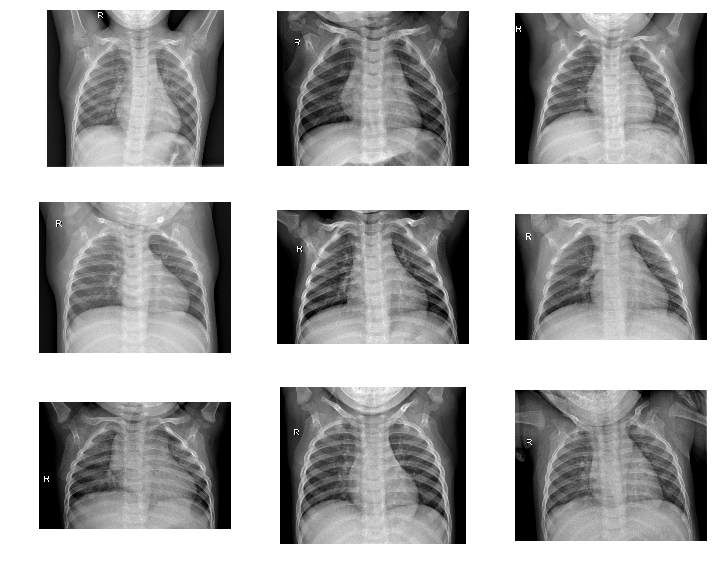

In [7]:
# Extract 9 random images from normal
random_images = [Normal[i] for i in range(9)]

print('Exibir Imagens Normal')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

Exibir Imagens Pneumonia


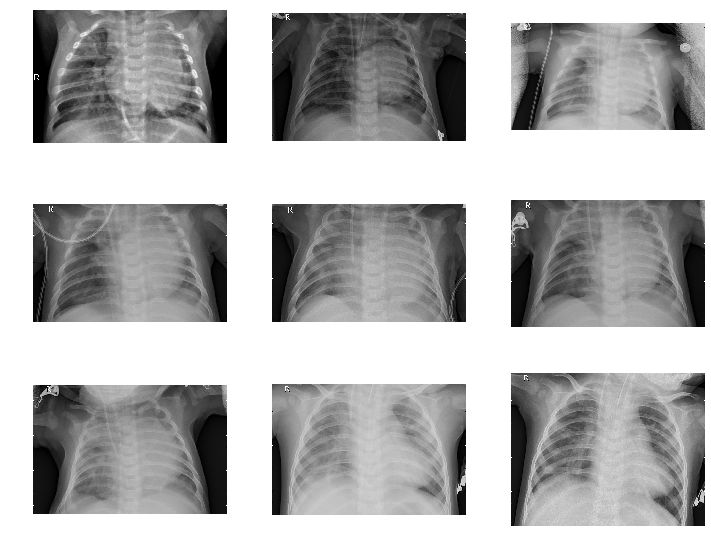

In [8]:
# Extract 9 random images from Pneumonia
random_images = [Pneumonia[i] for i in range(9)]

print('Exibir Imagens Pneumonia')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

In [9]:
images_shape = []

for k, image_path in enumerate(glob(train_dir + "\\*/*")):
    image = Image.open(image_path)
    images_shape.append(image.size)

images_shape_df = pd.DataFrame(data = images_shape, columns = ['H', 'W'], dtype='object')
images_shape_df['Size'] = '[' + images_shape_df['H'].astype(str) + ',' + images_shape_df['W'].astype(str) + ']'

In [10]:
images_shape_df.head()

,H,W,Size
0,2090,1858,"[2090,1858]"
1,1422,1152,"[1422,1152]"
2,1810,1434,"[1810,1434]"
3,1618,1279,"[1618,1279]"
4,1600,1125,"[1600,1125]"


In [11]:
print("Nós temos {} tipos diferentes nas imagens de treino".format(len(list(images_shape_df['Size'].unique()))))

Nós temos 4366 tipos diferentes nas imagens de treino


In [12]:
# define architecture

baseModel = efn.EfficientNetB5(weights = "imagenet", include_top = False, input_shape = (299, 299, 3))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid', name = "efficientnet_dense")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel, name = "EfficientNetB5")

model.trainable = True
model.summary()

Model: "EfficientNetB5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 48) 0           stem_bn[0][0]                    
_____________________________________________________________________________________

In [13]:
# image preprocessing
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir, 
                                                 target_size = (299, 299), 
                                                 batch_size = batch_size, 
                                                 class_mode = "binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (299, 299),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                          target_size = (299, 299),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# compile the model
opt = Adam(lr = 0.001)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [16]:
# this will help in reducing learning rate by factor of 0.1 when accuarcy will not improve
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.1, min_lr = 0.000001)

In [17]:
# define criteria for stopping. we will stop training if validation accuracy got reached 98%
class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') > 0.80):
			print("\nAlcançado 98% de acurácia então cancelar treino!")
			self.model.stop_training = True

callbacks = myCallback()

In [18]:
checkpoint_filepath = 'xray_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath,
                                            save_weights_only = True,
                                            monitor = 'val_acc',
                                            mode = 'max',
                                            save_best_only = True)

In [ ]:
#H = model.fit_generator(training_set,
#                        steps_per_epoch = training_set.samples//batch_size,
#                        validation_data = val_set,
#                        epochs = 10,
#                        validation_steps = val_set.samples,
#                        callbacks = [reduce_lr, callbacks, model_checkpoint_callback])

In [ ]:
model.fit(training_set,
          steps_per_epoch = training_set.samples//batch_size,
          validation_data = val_set,
          epochs = 10,
          validation_steps = val_set.samples)

Epoch 1/10


In [ ]:
print("Loss do modelo é - " , model.evaluate(test_set)[0])
print("Accuracy do modelo é - " , model.evaluate(test_set)[1]*100 , "%")

In [ ]:
# Extract 9 random images from normal
imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Exibindo Imagens Aleatórias')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = model.predict(img)
    
    if (prediction < 0.5):
        plt.title("Normal", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("Pneumonia", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

In [ ]:
# Let's try this one more time
imageset = glob(train_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Exibindo Imagens Aleatórias')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = model.predict(img)
    
    if (prediction < 0.5):
        plt.title("Normal", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("Pneumonia", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  